In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm_api
from statsmodels.tsa.stattools import adfuller
from tbats import TBATS
from pylab import rcParams
from utils.paths import DATA_RAW_DIR
from pathlib import Path
import matplotlib.dates as mdates
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [11]:
data_path = str(DATA_RAW_DIR / "train_jp.csv")
print(Path(data_path).exists())

True


In [12]:
df_sales = pd.read_csv(data_path, parse_dates=["date"])
df_sales.head()

,date,store,item,sales
0,2019-01-01,1,1,13
1,2019-01-02,1,1,11
2,2019-01-03,1,1,14
3,2019-01-04,1,1,13
4,2019-01-05,1,1,10


In [13]:
# Null data
df_sales.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [14]:
# duplicates
df_sales.duplicated().sum()

np.int64(0)

In [15]:
# dimensiones
df_sales.shape

(913000, 4)

In [16]:
# info
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [18]:
# filter dataframe by item and store
item = 4
store = 2
df_sales_filtered = df_sales[(df_sales["item"] == item)
                        & (df_sales["store"] == store)].copy()
# set date as index
df_sales_filtered.set_index("date", inplace=True)

In [19]:
df_sales_filtered.shape

(1826, 3)

In [20]:
df_sales_filtered.head()

,store,item,sales
date,,,
2019-01-01,2,4,21
2019-01-02,2,4,14
2019-01-03,2,4,12
2019-01-04,2,4,17
2019-01-05,2,4,14


In [22]:
df_sales_2 = df_sales_filtered['sales'].copy()
df_sales_2

date
2019-01-01    21
2019-01-02    14
2019-01-03    12
2019-01-04    17
2019-01-05    14
              ..
2023-12-27    26
2023-12-28    23
2023-12-29    21
2023-12-30    35
2023-12-31    29
Name: sales, Length: 1826, dtype: int64

In [39]:
# Reset index to prepare for plotting
df_sales_2_plot = df_sales_2.reset_index()
df_sales_2_plot['date'] = pd.to_datetime(df_sales_2_plot['date'], errors='coerce')

In [44]:
df_sales_2_plot.dropna(inplace=True)

In [45]:
df_sales_2_plot.shape

(1825, 2)

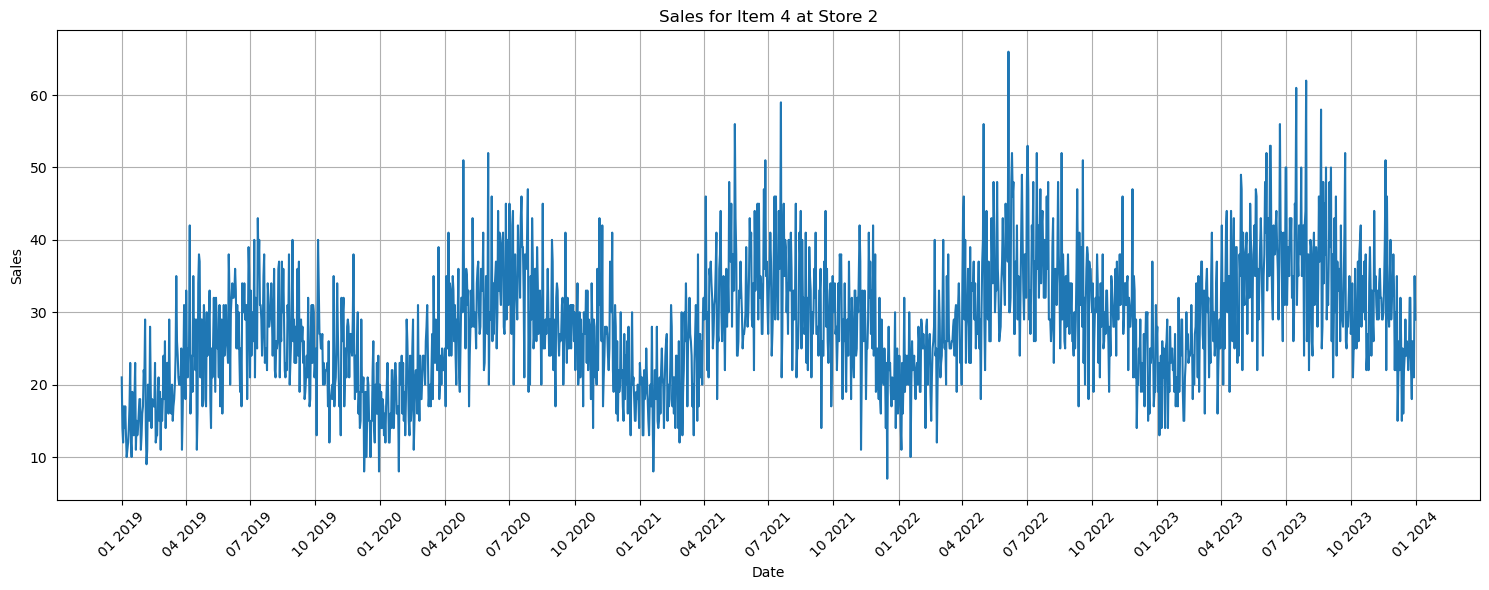

In [49]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the data
ax.plot(df_sales_2_plot['date'], df_sales_2_plot['sales'], linestyle='-')

# Set title and labels
ax.set_title(f'Sales for Item {item} at Store {store}')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')


plt.xticks(rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m %Y'))
plt.xticks(rotation=45)

# Optional styling
ax.grid(True)
plt.tight_layout()
plt.show()

In [54]:
df_sales_2_plot.head()

,date,sales
0,2019-01-01,21
1,2019-01-02,14
2,2019-01-03,12
3,2019-01-04,17
4,2019-01-05,14


In [ ]:
# 2019 sales data
df_sales_2019 = df_sales_2_plot[df_sales_2_plot['date'].dt.year == 2019].copy()
df_sales_2019.shape

(365, 2)

In [58]:
# december 2022 data
df_sales_dec_2022 = df_sales_2_plot[(df_sales_2_plot['date'].dt.month == 12) & (df_sales_2_plot['date'].dt.year == 2022)].copy()
df_sales_dec_2022.shape


(31, 2)

In [77]:
fig = make_subplots(rows=1,
                    cols=2,
                    subplot_titles=("2019 Sales", "December 2022 Sales"))

fig.add_trace(
    go.Scatter(x=df_sales_2019['date'],
                y=df_sales_2019['sales'],
                mode='lines+markers',
                name='2019 Sales'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df_sales_dec_2022['date'],
                y=df_sales_dec_2022['sales'],
                mode='lines+markers',
                name='December 2022 Sales'),
    row=1, col=2
)

fig.update_layout(
    title_text=f'Sales for Item {item} at Store {store}',
    xaxis_title='Date',
    yaxis_title='Sales',
    height=600,
    width=1200,
    showlegend=False
)

fig.update_xaxes(
    dtick="M3",  
    tickformat="%m %Y",  
    row=1, col=1
)

fig.update_xaxes(
    title_text='Date',
    dtick=3 * 24 * 60 * 60 * 1000,
    tickangle=45,
    tickformat="%d %m",
    row=1, col=2,

    
)

fig.update_yaxes(title_text='Sales')
fig.show()

# Stats

In [79]:
# Dickey-Fuller function



def dickey_fuller(series, signif_levels=[0.01, 0.05, 0.10], verbose=True):
    if series.isnull().any():
        raise ValueError("Null values found")

    result = adfuller(series, autolag='AIC')

    t_stat, p_value, n_lags, n_obs, crit_values, ic_best = result

    evaluation = {
        'ADF Test Statistic': t_stat,
        'p-value': p_value,
        'Used Lags': n_lags,
        'Observations': n_obs,
        'Critical Values': crit_values,
        'Stationary (by level)': {}
    }

    for level in signif_levels:
        key = f"{int(level * 100)}%"
        crit_val = crit_values[key]
        is_stationary = t_stat < crit_val
        evaluation['Stationary (by level)'][key] = is_stationary

    if verbose:
        print("🔎 Dickey-Fuller Test Results")
        print(f"Test Statistic: {t_stat:.4f}")
        print(f"p-value: {p_value:.4f}")
        print(f"Used Lags: {n_lags}")
        print(f"Number of Observations: {n_obs}")
        print("Critical Values:")
        for k, v in crit_values.items():
            print(f"  {k}: {v:.4f}")

        for level in signif_levels:
            key = f"{int(level * 100)}%"
            result_str = "Stationary" if evaluation['Stationary (by level)'][key] else " Not Stationary"
            print(f"{key} level: {result_str}")

        return None
    else:
        return evaluation

In [80]:
df_sales_2

date
2019-01-01    21
2019-01-02    14
2019-01-03    12
2019-01-04    17
2019-01-05    14
              ..
2023-12-27    26
2023-12-28    23
2023-12-29    21
2023-12-30    35
2023-12-31    29
Name: sales, Length: 1826, dtype: int64

In [81]:
dickey_fuller(df_sales_2, verbose=True)

🔎 Dickey-Fuller Test Results
Test Statistic: -2.9493
p-value: 0.0399
Used Lags: 22
Number of Observations: 1803
Critical Values:
  1%: -3.4340
  5%: -2.8631
  10%: -2.5676
1% level:  Not Stationary
5% level: Stationary
10% level: Stationary
